# Word Embedding

In this model, we will use neural network to classify the tweet sentiment.

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, cohen_kappa_score

import pickle

from timeit import default_timer as timer

from collections import Counter
from itertools import chain 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical, plot_model

from custom_functions import clean_up, evaluating, scoring, get_pred

In [118]:
import gc

# remove unnecessary variables
def clean_up(vars_):
    for var in vars_:
        del var 
    print(gc.collect())

In [119]:
X_train = pd.read_pickle('PKL/X_train_fin.pkl')
X_val = pd.read_pickle('PKL/X_val_fin.pkl')
y_train = pd.read_csv('DATA/y_train.csv', index_col=0)
y_val = pd.read_csv('DATA/y_val.csv', index_col=0)

In [120]:
X_train = X_train['tweet']
X_val = X_val['tweet']

In [121]:
y_train = y_train['sentiment']
y_val = y_val['sentiment']

## Input Setup
---
First, tokenize the words and pad them to be equal lengths.

In [122]:
num_vocab = 4000

In [123]:
tokenizer = Tokenizer(num_words = num_vocab)
tokenizer.fit_on_texts(X_train)

In [124]:
# convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [125]:
# add padding
X_train_seq = pad_sequences(X_train_seq)
X_val_seq = pad_sequences(X_val_seq, maxlen=len(X_train_seq[0]))

In [126]:
max_len = len(X_train_seq[0])

In [127]:
# Converting target to be a binary array
y_train_ohe = pd.get_dummies(y_train)
y_train = y_train_ohe.values
classes = list(y_train_ohe.columns)
y_val = pd.get_dummies(y_val).values

## LSTM
Without pretrained model, let's run simple LSTM.

In [169]:
model = Sequential()
model.add(Embedding(num_vocab, 200, input_length = max_len))
model.add(LSTM(200, dropout = 0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy', 
             metrics = ['categorical_accuracy'])

In [ ]:
cb = EarlyStopping(monitor = 'val_categorical_accuracy', mode = 'max', 
                   verbose = 1, patience = 5, restore_best_weights = True)

start = timer()
history = model.fit(X_train_seq, y_train,
                   epochs = 100, 
                   validation_data=(X_val_seq, y_val),
                   verbose = 2,  
                   callbacks = [cb], 
                   shuffle=True)

end = timer()
print('Total Time Elapsed:', end-start)

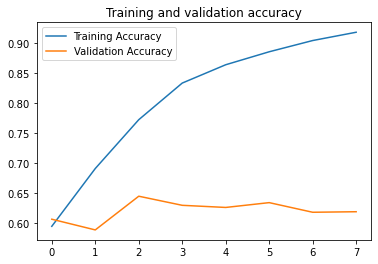

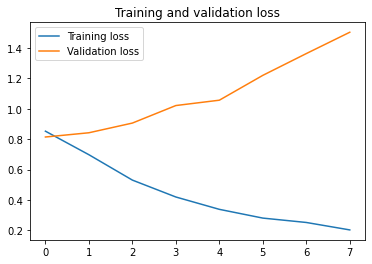

In [171]:
# plot performance
def plot_performance(hist):
    hist_ = hist.history
    epochs = hist.epoch

    plt.plot(epochs, hist_['categorical_accuracy'], label='Training Accuracy')
    plt.plot(epochs, hist_['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, hist_['loss'], label='Training loss')
    plt.plot(epochs, hist_['val_loss'], label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()
    
plot_performance(history)

In [172]:
def change_to_classes(target):
    tmp = np.argmax(target, axis = 1)
    return np.where(tmp == 0, classes[0], 
        np.where(tmp == 1, classes[1], classes[2]))

def evaluate(model, X_val_seq, target):
    scores = model.evaluate(X_val_seq, target, verbose = 0)
    print('Loss:', round(scores[0], 4))
    print('Categorical Accuracy:', round(scores[1], 4))
    y_pred = model.predict(X_val_seq)
    y_val = change_to_classes(target)
    y_pred = change_to_classes(y_pred)
    print('Cohens Kappa', round(cohen_kappa_score(y_val, y_pred), 4))
    print(classification_report(y_val, y_pred))

In [173]:
evaluate(model, X_val_seq, y_val)

Loss: 0.9064
Categorical Accuracy: 0.6453
Cohens Kappa 0.2594
                                    precision    recall  f1-score   support

                  Negative emotion       0.58      0.19      0.29        77
No emotion toward brand or product       0.66      0.86      0.75       654
                  Positive emotion       0.61      0.37      0.46       391

                          accuracy                           0.65      1122
                         macro avg       0.61      0.48      0.50      1122
                      weighted avg       0.63      0.65      0.62      1122



## LSTM Iter 2 - GloVe Twitter 200d
Now let's use pretrained workd embedding with GloVe. 

### GloVe
GloVe embeddings have pretrained data on twitter. I'll use that in the model.

In [77]:
from gensim.models import word2vec

In [ ]:
# building GloVe dictionary
#glove_path = '/Users/stereopickles/Documents/GloVe/glove.twitter.27B/glove.twitter.27B.200d.txt'
glove_path_pc = 'D:\Projects\GloVe_Twitter\glove.twitter.27B.200d.txt'
glove_dict = {}
with open(glove_path_pc, 'r', encoding = 'utf-8') as f:
    for line in f:
        vals = line.split(' ')
        glove_dict[vals[0]] = np.asarray(vals[1:], dtype = 'float32')

In [ ]:
# save dictionary
#with open ('PKL/GloVe_dict.pkl', 'wb') as fp:
#    pickle.dump(glove_dict, fp)

In [78]:
with open('PKL/GloVe_dict.pkl', 'rb') as fp:
    glove_dict = pickle.load(fp)

In [81]:
# get embeddings for each word from the GloVe
word_emb_mat = np.zeros((num_vocab, 200))
for i in range(1, num_vocab):
    word = tokenizer.index_word[i]
    if word in glove_dict:
        word_emb_mat[i] = glove_dict[word]

In [174]:
model = Sequential()
model.add(Embedding(num_vocab, 200, weights = [word_emb_mat],
                    input_length = max_len))
model.add(LSTM(200, dropout = 0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy', 
             metrics = ['categorical_accuracy'])

In [ ]:
start = timer()
history = model.fit(X_train_seq, y_train,
                   epochs = 100, 
                   validation_data=(X_val_seq, y_val),
                   verbose = 2,  
                   callbacks = [cb], 
                   shuffle=True)

end = timer()
print('Total Time Elapsed:', end-start)

In [ ]:
#model.save('MODEL/LSTM_v1.h5')

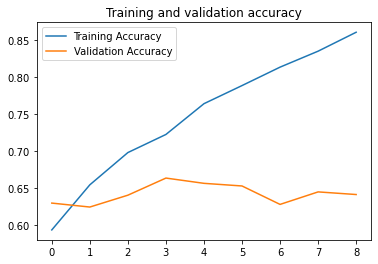

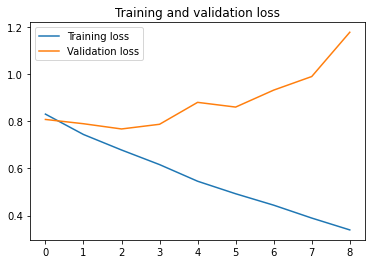

In [176]:
plot_performance(history)

In [177]:
evaluate(model, X_val_seq, y_val)

Loss: 0.7879
Categorical Accuracy: 0.6631
Cohens Kappa 0.2974
                                    precision    recall  f1-score   support

                  Negative emotion       0.44      0.10      0.17        77
No emotion toward brand or product       0.67      0.87      0.76       654
                  Positive emotion       0.65      0.43      0.52       391

                          accuracy                           0.66      1122
                         macro avg       0.59      0.47      0.48      1122
                      weighted avg       0.65      0.66      0.63      1122



Model is better but negative emotion classification isn't. Let's try to add class weights.

### Calculating Weights

In [194]:
from sklearn.utils import class_weight

In [200]:
y = np.argmax(y_train, axis = 1)
cw = class_weight.compute_class_weight('balanced', np.unique(y), y)
cw = dict(zip(np.unique(y), cw))

In [201]:
model = Sequential()
model.add(Embedding(num_vocab, 200, weights = [word_emb_mat],
                    input_length = max_len))
model.add(LSTM(200, dropout = 0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy', 
             metrics = ['categorical_accuracy'])

In [ ]:
start = timer()
history = model.fit(X_train_seq, y_train,
                   epochs = 100, 
                   validation_data=(X_val_seq, y_val),
                   verbose = 2,  
                   callbacks = [cb], 
                    class_weight=cw,
                   shuffle=True)

end = timer()
print('Total Time Elapsed:', end-start)

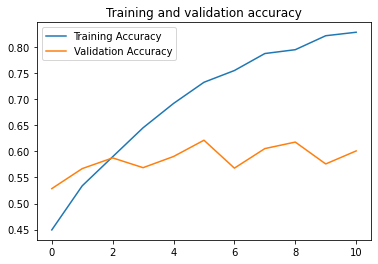

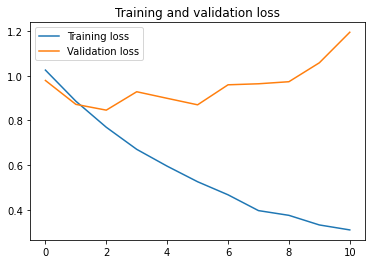

In [204]:
plot_performance(history)

In [203]:
evaluate(model, X_val_seq, y_val)

Loss: 0.8697
Categorical Accuracy: 0.6212
Cohens Kappa 0.3035
                                    precision    recall  f1-score   support

                  Negative emotion       0.34      0.34      0.34        77
No emotion toward brand or product       0.72      0.66      0.69       654
                  Positive emotion       0.54      0.61      0.57       391

                          accuracy                           0.62      1122
                         macro avg       0.53      0.54      0.53      1122
                      weighted avg       0.63      0.62      0.62      1122



That's the best macro-f1 so far. It's good that we included that weights. 